In [ ]:
import os, json, random, time
from collections import defaultdict, deque, Counter
from typing import Dict, Tuple, List
import numpy as np
from tabulate import tabulate

from environment3 import LifeStyleEnv

#  Discretization 
def _bin5(x: float, lo: float = 0.0, hi: float = 100.0) -> int:
    x = float(x); x = max(lo, min(hi, x))
    width = (hi - lo) / 5.0 if hi > lo else 1.0
    return min(4, int((x - lo) / width))

def _bin_bmi(bmi: float) -> int:
    b = float(bmi)
    if b < 16: return 0
    if b < 18.5: return 1
    if b < 22: return 2
    if b < 25: return 3
    if b < 27: return 4
    if b < 30: return 5
    if b < 35: return 6
    return 7

def state_key(obs) -> Tuple[int, int, int, int, int]:
    bmi    = float(obs["current_bmi"][0])
    stress = float(obs["current_stress_level"][0])
    energy = float(obs["current_energy_level"][0])
    hunger = float(obs["current_hunger_level"][0])
    tslot  = int(obs["current_timeslot"])  # 0..23
    tbin   = tslot // 3
    return (_bin_bmi(bmi), _bin5(stress), _bin5(energy), _bin5(hunger), tbin)

# Skip controls 
MAX_SKIPS_PER_DAY = 2         
LAMBDA_SKIP_ACTION = 2.0       # soft penalty when skipping during action/work
ACTION_BIAS = {                # tiny chooser bias against skip
    0:+0.05, 1:+0.07, 2:+0.07,
    3:+0.03, 4:+0.04, 5:+0.05,
    6:+0.02, 7:+0.02,
    8:-0.08,
}

def current_event(env) -> str:
    try:
        tslot = int(env.state["current_timeslot"])
        return env.daily_schedule[tslot] if tslot < len(env.daily_schedule) else "action"
    except Exception:
        return "action"

def get_valid_mask_with_cap(env: LifeStyleEnv, local_skip_count: int) -> np.ndarray:
    """Env mask intersected with our policy rule: max N skips/day in work/action slots."""
    if hasattr(env, "action_masks"):
        m = np.asarray(env.action_masks(), dtype=bool)
    elif hasattr(env, "get_action_mask"):
        m = np.asarray(env.get_action_mask(), dtype=bool)
    else:
        m = np.ones(env.action_space.n, dtype=bool)

    event = current_event(env)
    if event in ("action", "work") and local_skip_count >= MAX_SKIPS_PER_DAY and len(m) > 8:
        m[8] = False
    return m

BEST_PATH = "saved_models/dyna_q_final_best.json"
os.makedirs(os.path.dirname(BEST_PATH), exist_ok=True)

def save_q(Q: Dict[Tuple, float], path: str = BEST_PATH):
    payload = {str(k): float(v) for k, v in Q.items()}
    with open(path, "w") as f:
        json.dump(payload, f)

def load_q(path: str = BEST_PATH) -> Dict[Tuple, float]:
    with open(path, "r") as f:
        data = json.load(f)
    return {eval(k): float(v) for k, v in data.items()}

# Greedy evaluation 
ACTION_NAME = {
    0:"meal: light", 1:"meal: medium", 2:"meal: heavy",
    3:"exercise: light", 4:"exercise: moderate", 5:"exercise: intense",
    6:"rest: light", 7:"rest: deep", 8:"skip"
}

def _scalar(x):
    if isinstance(x, np.ndarray):
        return x.item() if x.size == 1 else x
    return x

def run_episode(Q: Dict[Tuple, float], seed=999, **env_kwargs):
    env = LifeStyleEnv(**env_kwargs)
    obs, info = env.reset(seed=seed)

    s = state_key(obs)
    done = False
    rows: List[List] = []
    total_reward = 0.0
    hist = Counter()
    skip_today = 0  

    while not done:
        if int(obs["current_timeslot"]) == 0:
            skip_today = 0

        mask = get_valid_mask_with_cap(env, local_skip_count=skip_today)
        idx = np.where(mask)[0]
        if len(idx) == 0:
            a = 0
        else:
            a = int(max(idx, key=lambda aa: Q.get((s, int(aa)), 0.0)))

        obs2, r, term, trunc, _ = env.step(a)
        total_reward += float(r)
        hist[a] += 1
        if a == 8:  
            skip_today += 1
        day  = int(_scalar(obs.get("day_of_episode", 0)))
        slot = int(obs["current_timeslot"])
        event = env.daily_schedule[slot] if hasattr(env, "daily_schedule") and slot < len(env.daily_schedule) else ""

        rows.append([
            day, slot, ACTION_NAME.get(a, str(a)), event,
            f"{float(obs['current_bmi'][0]):.2f}",
            f"{float(obs['current_stress_level'][0]):.2f}",
            f"{float(obs['current_energy_level'][0]):.2f}",
            f"{float(obs['current_hunger_level'][0]):.2f}",
            f"{float(obs['daily_calories_intake']):.2f}",
            f"{float(obs['daily_calories_burned']):.2f}",
            f"{float(r):.2f}",
        ])

        s, obs, done = state_key(obs2), obs2, bool(term or trunc)

    env.close()
    return rows, total_reward, hist

def print_episode(rows, total_reward, hist, title="Summary"):
    headers = ["Day","Timeslot","Action","Event","BMI","Stress","Energy","Hunger","Cal. Intake","Cal. Burned","Reward"]
    print(tabulate(rows[:30], headers=headers, tablefmt="pretty"))
    steps = sum(hist.values())
    skip_ratio = hist.get(8,0)/max(steps,1)
    print(f"\n— {title} —")
    print(f"Total steps: {steps}")
    print(f"Total return (sum of rewards): {total_reward:.2f}")
    print(f"Action usage: {dict(sorted(hist.items()))}")
    print(f"Skip ratio: {skip_ratio:.2%}")

def evaluate_scenarios(Q, seed=999):
    results = {}
    for w0, name in [(45.0,"Underweight"), (70.0,"Normal"), (85.0,"Overweight")]:
        rows, tot, hist = run_episode(Q, seed=seed, initial_weight_kg=w0, days_per_episode=365)
        print_episode(rows, tot, hist, title=name)
        results[name] = tot
    return results

def eval_three(Q, seeds=(999, 1001, 1003), days=365):
    def mean_score(w0):
        scores = []
        for sd in seeds:
            _, tot, _ = run_episode(Q, seed=sd, initial_weight_kg=w0, days_per_episode=days)
            scores.append(tot)
        return float(np.mean(scores))
    return {
        "Underweight": mean_score(45.0),
        "Normal":      mean_score(70.0),
        "Overweight":  mean_score(85.0),
    }



# Dyna-Q trainer

In [2]:
def evaluate_mean_return(Q, seeds=(999,1001,1003), w_list=(45.0,70.0,85.0)):
    scores = []
    for w0 in w_list:
        for sd in seeds:
            _, tot, _ = run_episode(Q, seed=sd, initial_weight_kg=w0, days_per_episode=365)
            scores.append(tot)
    return float(np.mean(scores))


def train_dyna_q(
    episodes=600,
    alpha=0.07,
    gamma=0.99,
    planning_steps=25,
    ucb_c=1.2,
    seed=4242,
    eval_every=50,
    Q_init: Dict[Tuple, float] | None = None,
    save_path: str = BEST_PATH,
    curriculum_weights=(45.0, 70.0, 85.0),
):
    random.seed(seed); np.random.seed(seed)
    env = LifeStyleEnv(days_per_episode=365)
    Q = defaultdict(float)
    if Q_init:
        Q.update(Q_init)

    model = {}
    seen_pairs = deque(maxlen=50000)
    ucb_counts = {}
    total_steps = 0

    # telemetry
    returns = []
    ep_skip_ratios = []
    ep_lengths = []
    scenario_steps = []
    scenario_under = []
    scenario_norm  = []
    scenario_over  = []

    best_metric = -1e18
    best_snapshot = None

    for ep in range(1, episodes+1):
        w0 = random.choice(curriculum_weights)
        obs, _ = env.reset(seed=seed + ep, options={"initial_weight_kg": w0, "days_per_episode": 365})
        s = state_key(obs)
        done = False
        ep_ret = 0.0
        skip_today = 0
        skip_total = 0
        ep_len = 0

        while not done:
            if int(obs["current_timeslot"]) == 0:
                skip_today = 0

            valid = get_valid_mask_with_cap(env, local_skip_count=skip_today)
            idx = np.where(valid)[0]
            t = max(total_steps + 1, 1)

            # UCB + slight bias
            if len(idx) == 0:
                a = 0
            else:
                best_a, best_score = 0, -1e18
                for a_ in idx:
                    n_sa = ucb_counts.get((s, int(a_)), 0)
                    bonus = ucb_c * np.sqrt(np.log(t) / (n_sa + 1.0))
                    q = Q.get((s, int(a_)), 0.0)
                    bias = ACTION_BIAS.get(int(a_), 0.0)
                    score = q + bonus + bias
                    if score > best_score:
                        best_score, best_a = score, int(a_)
                a = best_a

            # Step
            prev_event = current_event(env)
            obs2, r, term, trunc, _ = env.step(a)

            # soft penalty for skipping during action/work
            if a == 8 and prev_event in ("action", "work"):
                r = float(r) - LAMBDA_SKIP_ACTION

            total_steps += 1
            ep_len += 1
            ep_ret += float(r)

            s2 = state_key(obs2)
            done = bool(term or trunc)
            if a == 8:
                skip_today += 1
                skip_total += 1

            # TD update
            ucb_counts[(s, a)] = ucb_counts.get((s, a), 0) + 1
            valid_next = get_valid_mask_with_cap(env, local_skip_count=skip_today)
            idx_next = np.where(valid_next)[0]
            max_next = max((Q.get((s2, int(a2)), 0.0) for a2 in idx_next), default=0.0)
            Q[(s, a)] = Q.get((s, a), 0.0) + alpha * (r + gamma * max_next - Q.get((s, a), 0.0))

            # Dyna planning
            key = (s, a)
            model[key] = (s2, float(r), tuple(int(i) for i in idx_next))
            seen_pairs.append(key)

            for _ in range(planning_steps if seen_pairs else 0):
                sp, ap = random.choice(seen_pairs)
                sp2, rp, idx_next_model = model[(sp, ap)]
                max_p = max((Q.get((sp2, int(a2)), 0.0) for a2 in idx_next_model), default=0.0)
                Q[(sp, ap)] = Q.get((sp, ap), 0.0) + alpha * (rp + gamma * max_p - Q.get((sp, ap), 0.0))

            s = s2

        # episode bookkeeping
        returns.append(ep_ret)
        ep_lengths.append(ep_len)
        ep_skip_ratios.append(skip_total / max(ep_len, 1))
        total_tsteps = int(np.sum(ep_lengths))

        # periodic evaluation (balanced)
        if ep % eval_every == 0:
            metric = evaluate_mean_return(Q)
            last10 = np.mean(returns[-10:]) if len(returns) >= 10 else np.mean(returns)
            print(f"[ep {ep:04d}] last10={last10:.2f}  mean_eval={metric:.2f}  best={best_metric:.2f}")

            s = eval_three(Q)
            scenario_steps.append(total_tsteps)
            scenario_under.append(s["Underweight"])
            scenario_norm.append(s["Normal"])
            scenario_over.append(s["Overweight"])

            if metric > best_metric:
                best_metric = metric
                best_snapshot = dict(Q)
                save_q(best_snapshot, save_path)

    env.close()

    # pack telemetry for plotting
    telemetry = {
        "returns": np.array(returns, dtype=float),
        "skip_ratio": np.array(ep_skip_ratios, dtype=float),
        "ep_len": np.array(ep_lengths, dtype=int),
        "scenario_steps": np.array(scenario_steps, dtype=int),
        "scenario_under": np.array(scenario_under, dtype=float),
        "scenario_norm":  np.array(scenario_norm,  dtype=float),
        "scenario_over":  np.array(scenario_over,  dtype=float),
    }

    if best_snapshot is not None:
        save_q(best_snapshot, save_path)
        return best_snapshot, telemetry
    else:
        save_q(Q, save_path)
        return dict(Q), telemetry

# Train & Save

In [3]:
Q_trained, tele = train_dyna_q(
    episodes=600,
    alpha=0.07,
    planning_steps=25,
    ucb_c=1.2,
    eval_every=50,
    save_path=BEST_PATH,
    curriculum_weights=(45.0, 70.0, 85.0),
)
print("Saved best model to:", BEST_PATH)


/tmp/ipykernel_8086/2989315880.py:128: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f"{float(obs['daily_calories_intake']):.2f}",
/tmp/ipykernel_8086/2989315880.py:129: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f"{float(obs['daily_calories_burned']):.2f}",


[ep 0050] last10=60898.53  mean_eval=593.99  best=-1000000000000000000.00
[ep 0100] last10=59888.26  mean_eval=-1277.73  best=593.99
[ep 0150] last10=68800.27  mean_eval=-109.61  best=593.99
[ep 0200] last10=70448.74  mean_eval=18933.85  best=593.99
[ep 0250] last10=70207.94  mean_eval=24366.84  best=18933.85
[ep 0300] last10=69796.00  mean_eval=22749.74  best=24366.84
[ep 0350] last10=71303.51  mean_eval=24994.87  best=24366.84
[ep 0400] last10=71655.09  mean_eval=24614.91  best=24994.87
[ep 0450] last10=68770.69  mean_eval=-785.57  best=24994.87
[ep 0500] last10=70438.72  mean_eval=31720.93  best=24994.87
[ep 0550] last10=70175.13  mean_eval=24314.90  best=31720.93
[ep 0600] last10=68019.97  mean_eval=24678.29  best=31720.93
Saved best model to: training/saved_models/dyna_q_final_best.json


# Evaluate in 3 scenarios 

In [4]:
Q_best = load_q(BEST_PATH)
scenario_scores = evaluate_scenarios(Q_best, seed=4242)
print("\nScenario returns:", scenario_scores)

+-----+----------+-------------+--------+-------+--------+--------+--------+-------------+-------------+--------+
| Day | Timeslot |   Action    | Event  |  BMI  | Stress | Energy | Hunger | Cal. Intake | Cal. Burned | Reward |
+-----+----------+-------------+--------+-------+--------+--------+--------+-------------+-------------+--------+
|  0  |    0     |    skip     | sleep  | 15.57 | 50.00  | 50.00  | 50.00  |    0.00     |    0.00     |  0.62  |
|  0  |    1     |    skip     | sleep  | 15.57 | 46.00  | 54.00  | 48.00  |    0.00     |    42.53    |  1.43  |
|  0  |    2     |    skip     | sleep  | 15.57 | 42.00  | 58.00  | 46.00  |    0.00     |    85.05    |  2.23  |
|  0  |    3     |    skip     | sleep  | 15.57 | 38.00  | 62.00  | 44.00  |    0.00     |   127.57    |  2.99  |
|  0  |    4     |    skip     | sleep  | 15.57 | 34.00  | 66.00  | 42.00  |    0.00     |   170.10    |  3.74  |
|  0  |    5     |    skip     | sleep  | 15.57 | 30.00  | 70.00  | 40.00  |    0.00    

/tmp/ipykernel_8086/2989315880.py:128: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f"{float(obs['daily_calories_intake']):.2f}",
/tmp/ipykernel_8086/2989315880.py:129: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f"{float(obs['daily_calories_burned']):.2f}",


+-----+----------+-------------------+--------+-------+--------+--------+--------+-------------+-------------+--------+
| Day | Timeslot |      Action       | Event  |  BMI  | Stress | Energy | Hunger | Cal. Intake | Cal. Burned | Reward |
+-----+----------+-------------------+--------+-------+--------+--------+--------+-------------+-------------+--------+
|  0  |    0     |       skip        | sleep  | 29.41 | 50.00  | 50.00  | 50.00  |    0.00     |    0.00     |  1.17  |
|  0  |    1     |       skip        | sleep  | 29.41 | 46.00  | 54.00  | 48.00  |    0.00     |    80.32    |  2.54  |
|  0  |    2     |       skip        | sleep  | 29.41 | 42.00  | 58.00  | 46.00  |    0.00     |   160.65    |  3.88  |
|  0  |    3     |       skip        | sleep  | 29.41 | 38.00  | 62.00  | 44.00  |    0.00     |   240.98    |  5.21  |
|  0  |    4     |       skip        | sleep  | 29.41 | 34.00  | 66.00  | 42.00  |    0.00     |   321.30    |  6.50  |
|  0  |    5     |       skip        | s

# Fine-tune specifically for Underweight

In [ ]:
def fine_tune_underweight(
    base_path=BEST_PATH,               
    save_path="saved_models/dyna_q_final_best.json",  
    episodes=400,
    alpha=0.10,                         
    gamma=0.99,
    planning_steps=10,                  
    ucb_c=0.6,                       
    seed=4242,
    eps_start=0.25,                     
    eps_end=0.02,                       
    eps_decay=0.995,                 
    eval_every=20,                      
):
  
    if os.path.exists(base_path):
        Q = defaultdict(float, load_q(base_path))
        print(f"Loaded base Q from {base_path} ({len(Q)} entries).")
    else:
        Q = defaultdict(float)
        print("Base Q not found. Starting from scratch.")

    rng = np.random.RandomState(seed)
    random.seed(seed); np.random.seed(seed)

    model = {}
    seen_pairs = deque(maxlen=50000)
    ucb_counts = {}
    total_steps = 0

    epsilon = float(eps_start)
    best_eval = -1e18
    best_snapshot = dict(Q)  
    eval_history = []
    ft_steps = []
    ft_under = []
    ft_norm  = []
    ft_over  = []
    total_ft_steps = 0

    def pick_action_ucb_eps(s, valid_idx, t):
        if len(valid_idx) == 0:
            return 0
        if rng.rand() < epsilon:                 
            return int(rng.choice(valid_idx))
        # UCB + small chooser bias
        best_a, best_score = int(valid_idx[0]), -1e18
        for a_ in valid_idx:
            n_sa = ucb_counts.get((s, int(a_)), 0)
            bonus = ucb_c * np.sqrt(np.log(max(t, 1)) / (n_sa + 1.0))
            q = Q.get((s, int(a_)), 0.0)
            bias = ACTION_BIAS.get(int(a_), 0.0)
            score = q + bonus + bias
            if score > best_score:
                best_score, best_a = score, int(a_)
        return best_a

    # training loop (UNDERWEIGHT only)
    for ep in range(1, episodes + 1):
        env = LifeStyleEnv(initial_weight_kg=45.0, days_per_episode=365)
        obs, _ = env.reset(seed=seed + ep)

        s = state_key(obs)
        done = False
        skip_today = 0

        while not done:
            if int(obs["current_timeslot"]) == 0:
                skip_today = 0

            valid_mask = get_valid_mask_with_cap(env, local_skip_count=skip_today)
            valid_idx = np.where(valid_mask)[0]

            t = max(total_steps + 1, 1)
            a = pick_action_ucb_eps(s, valid_idx, t)

            prev_event = current_event(env)
            obs2, r, term, trunc, _ = env.step(a)

            # soft penalty for skipping during action/work
            if a == 8 and prev_event in ("action", "work"):
                r = float(r) - LAMBDA_SKIP_ACTION

            total_steps += 1
            s2 = state_key(obs2)
            done = bool(term or trunc)
            if a == 8:
                skip_today += 1

            # TD
            ucb_counts[(s, a)] = ucb_counts.get((s, a), 0) + 1
            valid_next = get_valid_mask_with_cap(env, local_skip_count=skip_today)
            idx_next = np.where(valid_next)[0]
            max_next = max((Q.get((s2, int(a2)), 0.0) for a2 in idx_next), default=0.0)
            Q[(s, a)] = Q.get((s, a), 0.0) + alpha * (r + gamma * max_next - Q.get((s, a), 0.0))

            # Dyna
            key = (s, a)
            model[key] = (s2, float(r), tuple(int(i) for i in idx_next))
            seen_pairs.append(key)
            for _ in range(planning_steps if seen_pairs else 0):
                sp, ap = random.choice(seen_pairs)
                sp2, rp, idx_next_model = model[(sp, ap)]
                max_p = max((Q.get((sp2, int(a2)), 0.0) for a2 in idx_next_model), default=0.0)
                Q[(sp, ap)] = Q.get((sp, ap), 0.0) + alpha * (rp + gamma * max_p - Q.get((sp, ap), 0.0))

            s = s2
            obs = obs2

        total_ft_steps += 365

        # decay ε
        epsilon = max(eps_end, epsilon * eps_decay)

        # Periodic evaluation on Underweight ONLY, multiple seeds for stability
        if ep % eval_every == 0:
            seeds = (2025, 2027, 2031)
            scores = []
            for sd in seeds:
                _, tot, _ = run_episode(Q, seed=sd, initial_weight_kg=45.0, days_per_episode=365)
                scores.append(tot)
            mean_eval = float(np.mean(scores))
            eval_history.append(mean_eval)
            print(f"[UW fine-tune ep {ep:04d}] mean_eval={mean_eval:.2f} (best={best_eval:.2f})  eps={epsilon:.3f}")
            s_all = eval_three(Q)
            ft_steps.append(total_ft_steps)
            ft_under.append(s_all["Underweight"])
            ft_norm.append(s_all["Normal"])
            ft_over.append(s_all["Overweight"])

            if mean_eval > best_eval:
                best_eval = mean_eval
                best_snapshot = dict(Q)
                save_q(best_snapshot, save_path)
                print(f"  ↳ Saved better UW model to: {save_path} at {time.ctime(os.path.getmtime(save_path))}")

    # Always persist the best snapshot
    save_q(best_snapshot, save_path)
    print("Fine-tune complete. Best UW Q saved to:", save_path)

    return best_snapshot, {
        "uw_eval_history": np.array(eval_history, dtype=float),
        "ft_steps": np.array(ft_steps, dtype=int),
        "ft_under": np.array(ft_under, dtype=float),
        "ft_norm":  np.array(ft_norm,  dtype=float),
        "ft_over":  np.array(ft_over,  dtype=float),
    }



 # Re-evaluate after fine-tune

In [ ]:
Q_uw, tele_uw = fine_tune_underweight(
    base_path=BEST_PATH,
    save_path="saved_models/dyna_q_final_best.json",
    episodes=400
)

scenario_scores_after = evaluate_scenarios(Q_uw, seed=4242)
print("\nScenario returns AFTER UW fine-tune:", scenario_scores_after)

Loaded base Q from training/saved_models/dyna_q_final_best.json (649 entries).
[UW fine-tune ep 0020] mean_eval=9870.21 (best=-1000000000000000000.00)  eps=0.226


/tmp/ipykernel_8086/2989315880.py:128: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f"{float(obs['daily_calories_intake']):.2f}",
/tmp/ipykernel_8086/2989315880.py:129: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f"{float(obs['daily_calories_burned']):.2f}",


  ↳ Saved better UW model to: training/saved_models/dyna_q_final_best.json at Thu Sep  4 20:07:53 2025
[UW fine-tune ep 0040] mean_eval=9160.49 (best=9870.21)  eps=0.205
[UW fine-tune ep 0060] mean_eval=6677.88 (best=9870.21)  eps=0.185
[UW fine-tune ep 0080] mean_eval=7960.73 (best=9870.21)  eps=0.167
[UW fine-tune ep 0100] mean_eval=8631.74 (best=9870.21)  eps=0.151
[UW fine-tune ep 0120] mean_eval=12360.64 (best=9870.21)  eps=0.137
  ↳ Saved better UW model to: training/saved_models/dyna_q_final_best.json at Thu Sep  4 20:08:03 2025
[UW fine-tune ep 0140] mean_eval=7680.20 (best=12360.64)  eps=0.124
[UW fine-tune ep 0160] mean_eval=9402.44 (best=12360.64)  eps=0.112
[UW fine-tune ep 0180] mean_eval=12060.34 (best=12360.64)  eps=0.101
[UW fine-tune ep 0200] mean_eval=9230.21 (best=12360.64)  eps=0.092
[UW fine-tune ep 0220] mean_eval=3788.15 (best=12360.64)  eps=0.083
[UW fine-tune ep 0240] mean_eval=10592.60 (best=12360.64)  eps=0.075
[UW fine-tune ep 0260] mean_eval=9379.71 (best=1

# Plot Learning Curves

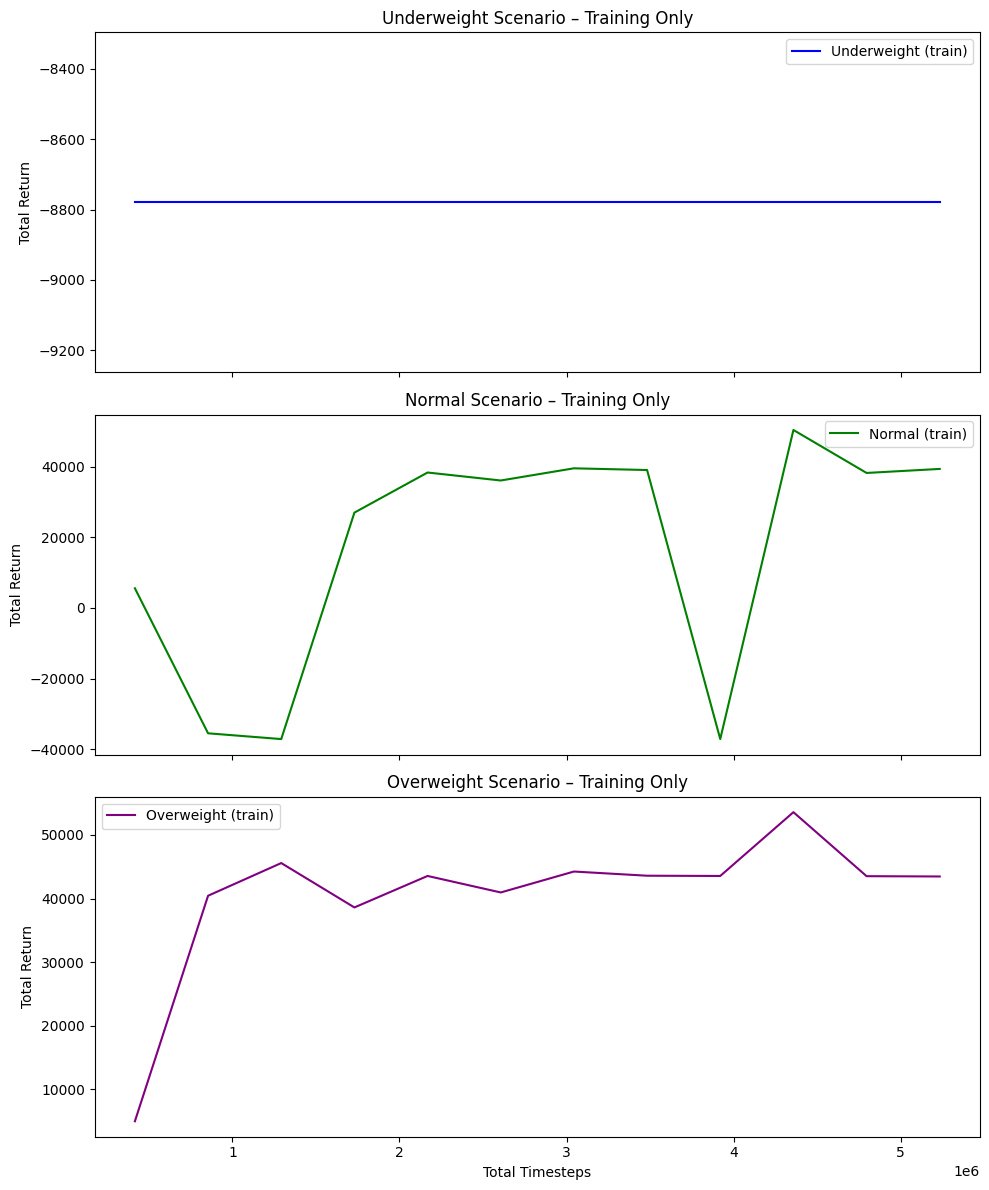

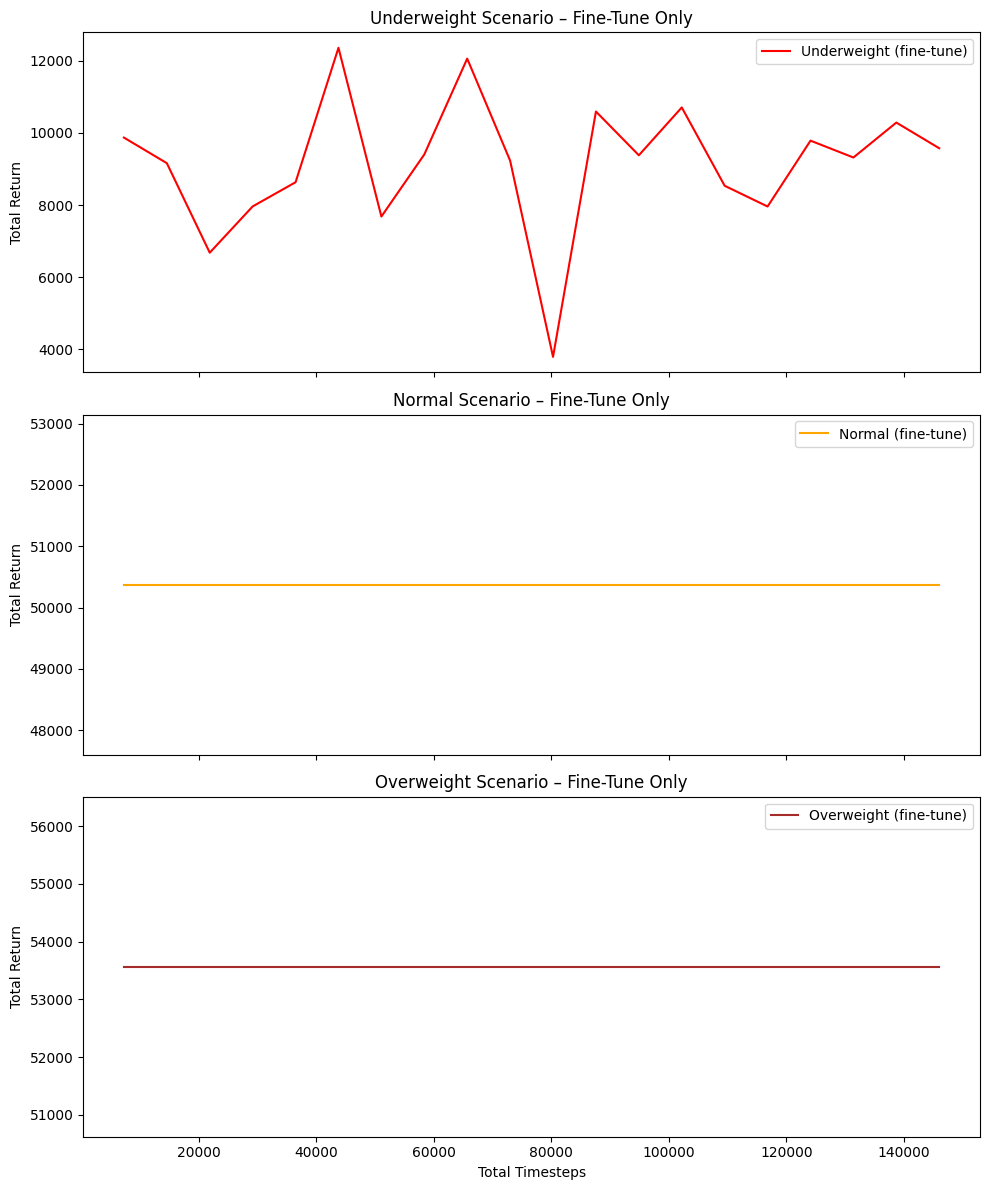

In [7]:
import matplotlib.pyplot as plt

# --- Training telemetry (no fine-tune) ---
steps_tr = tele.get("scenario_steps", np.array([]))
uw_tr    = tele.get("scenario_under", np.array([]))
nm_tr    = tele.get("scenario_norm",  np.array([]))
ow_tr    = tele.get("scenario_over",  np.array([]))

# --- Fine-tune telemetry (only if available) ---
ft_steps = tele_uw.get("ft_steps", np.array([])) if 'tele_uw' in globals() else np.array([])
uw_ft    = tele_uw.get("ft_under", np.array([])) if 'tele_uw' in globals() else np.array([])
nm_ft    = tele_uw.get("ft_norm",  np.array([])) if 'tele_uw' in globals() else np.array([])
ow_ft    = tele_uw.get("ft_over",  np.array([])) if 'tele_uw' in globals() else np.array([])

# =================================================
# Part 1: Training only
# =================================================
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

axes[0].plot(steps_tr, uw_tr, label="Underweight (train)", color="blue")
axes[0].set_title("Underweight Scenario – Training Only")
axes[0].set_ylabel("Total Return")
axes[0].legend()

axes[1].plot(steps_tr, nm_tr, label="Normal (train)", color="green")
axes[1].set_title("Normal Scenario – Training Only")
axes[1].set_ylabel("Total Return")
axes[1].legend()

axes[2].plot(steps_tr, ow_tr, label="Overweight (train)", color="purple")
axes[2].set_title("Overweight Scenario – Training Only")
axes[2].set_xlabel("Total Timesteps")
axes[2].set_ylabel("Total Return")
axes[2].legend()

plt.tight_layout()
plt.show()

# =================================================
# Part 2: Fine-tune only
# =================================================
if ft_steps.size:
    fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

    axes[0].plot(ft_steps, uw_ft, label="Underweight (fine-tune)", color="red")
    axes[0].set_title("Underweight Scenario – Fine-Tune Only")
    axes[0].set_ylabel("Total Return")
    axes[0].legend()

    axes[1].plot(ft_steps, nm_ft, label="Normal (fine-tune)", color="orange")
    axes[1].set_title("Normal Scenario – Fine-Tune Only")
    axes[1].set_ylabel("Total Return")
    axes[1].legend()

    axes[2].plot(ft_steps, ow_ft, label="Overweight (fine-tune)", color="brown")
    axes[2].set_title("Overweight Scenario – Fine-Tune Only")
    axes[2].set_xlabel("Total Timesteps")
    axes[2].set_ylabel("Total Return")
    axes[2].legend()

    plt.tight_layout()
    plt.show()
